# necessary imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

import typing
from datetime import datetime, timedelta

# read the raw training data

In [53]:
df = pd.read_pickle('stock_data.pickle')
df.head()

,ticker,date,price,price_1m,price_6m,price_1y,market,sector,industry,net_income,revenue,research_and_development_expenses,eps,book_value_per_share,current_ratio,long_term_debt_2_capital,debt2equity_ratio,total_non_operating_income2expense
0,AAPL,2020-06-30,360.079987,376.750000,NaN,NaN,us_market,Technology,Consumer Electronics,11253.0,59685.0,4758.0,2.58,16.8728,1.4695,0.5654,1.5595,46.0
1,AAPL,2020-03-31,255.600006,289.959991,NaN,NaN,us_market,Technology,Consumer Electronics,11249.0,58313.0,4565.0,2.55,18.1372,1.4960,0.5318,1.3963,282.0
2,AAPL,2019-12-31,289.929993,320.540009,353.250000,NaN,us_market,Technology,Consumer Electronics,22236.0,91819.0,4451.0,4.99,20.4178,1.5978,0.5097,1.2095,349.0
3,AAPL,2019-09-30,220.899994,244.759995,250.740005,NaN,us_market,Technology,Consumer Electronics,13686.0,64040.0,4110.0,3.07,20.3653,1.5401,0.5036,1.1940,502.0
4,AAPL,2019-06-30,203.169998,208.759995,291.119995,353.25,us_market,Technology,Consumer Electronics,10044.0,53809.0,4257.0,2.18,21.2862,1.5046,0.4682,1.1240,367.0


In [49]:
df['earnings2price'] = df['eps'] / df['price']
df['book2price'] = df['book_value_per_share'] / df['price']
df['month'] = df['date'].dt.month

df['gain_1m'] = df['price_1m'] / df['price']
df['gain_6m'] = df['price_6m'] / df['price']
df['gain_1y'] = df['price_1y'] / df['price']

# So negative gain is a negative number 
df['gain_1m'] = np.log(df['gain_1m'])
df['gain_6m'] = np.log(df['gain_6m'])
df['gain_1y'] = np.log(df['gain_1y'])

df.head()

,ticker,date,price,price_1m,price_6m,price_1y,market,sector,industry,net_income,...,current_ratio,long_term_debt_2_capital,debt2equity_ratio,total_non_operating_income2expense,earnings2price,book2price,month,gain_1m,gain_6m,gain_1y
0,AAPL,2020-06-30,360.079987,376.750000,NaN,NaN,us_market,Technology,Consumer Electronics,11253.0,...,1.4695,0.5654,1.5595,46.0,0.007165,0.046858,6,0.045256,NaN,NaN
1,AAPL,2020-03-31,255.600006,289.959991,NaN,NaN,us_market,Technology,Consumer Electronics,11249.0,...,1.4960,0.5318,1.3963,282.0,0.009977,0.070959,3,0.126129,NaN,NaN
2,AAPL,2019-12-31,289.929993,320.540009,353.250000,NaN,us_market,Technology,Consumer Electronics,22236.0,...,1.5978,0.5097,1.2095,349.0,0.017211,0.070423,12,0.100368,0.197537,NaN
3,AAPL,2019-09-30,220.899994,244.759995,250.740005,NaN,us_market,Technology,Consumer Electronics,13686.0,...,1.5401,0.5036,1.1940,502.0,0.013898,0.092192,9,0.102568,0.126706,NaN
4,AAPL,2019-06-30,203.169998,208.759995,291.119995,353.25,us_market,Technology,Consumer Electronics,10044.0,...,1.5046,0.4682,1.1240,367.0,0.010730,0.104770,6,0.027142,0.359692,0.553133


# specify categorical and continuous columns
Categorical columns will use embedding

In [4]:
cat_cols = 'sector industry month'.split()# market
for col in cat_cols:
    df[col] = df[col].fillna('?')
    df[col] = df[col].astype('category')

In [5]:
con_cols = 'net_income revenue earnings2price book2price current_ratio long_term_debt_2_capital debt2equity_ratio total_non_operating_income2expense'.split()

# specify cols to predict

In [6]:
lbl_cols = 'gain_1y'.split()

# types

In [7]:
df.dtypes

ticker                                        string
date                                  datetime64[ns]
price                                        float64
price_1m                                     float64
price_6m                                     float64
price_1y                                     float64
market                                        string
sector                                      category
industry                                    category
net_income                                   float64
revenue                                      float64
research_and_development_expenses            float64
earnings2price                               float64
book2price                                   float64
current_ratio                                float64
long_term_debt_2_capital                     float64
debt2equity_ratio                            float64
total_non_operating_income2expense           float64
month                                       ca

# current data

In [8]:
latest = df.loc[0][['ticker', *cat_cols, *con_cols, 'date']]
latest = latest.dropna()
latest.head()

,ticker,sector,industry,month,net_income,revenue,earnings2price,book2price,current_ratio,long_term_debt_2_capital,debt2equity_ratio,total_non_operating_income2expense,date
0,AAPL,Technology,Consumer Electronics,6,11253.0,59685.0,0.007165,0.046858,1.4695,0.5654,1.5595,46.0,2020-06-30
0,AMZN,Consumer Cyclical,Internet Retail,6,5243.0,88912.0,0.003836,0.054807,1.1812,0.3100,0.4493,378.0,2020-06-30
0,GOOG,Communication Services,Internet Content & Information,6,6959.0,38297.0,0.007285,0.216538,3.4145,0.0663,0.0710,1894.0,2020-06-30
0,GOOGL,Communication Services,Internet Content & Information,6,6959.0,38297.0,0.007252,0.215539,3.4145,0.0663,0.0710,1894.0,2020-06-30
0,MSFT,Technology,Software—Infrastructure,6,11202.0,38033.0,0.007429,0.078967,2.5158,0.3624,0.6001,15.0,2020-06-30


# data for training

In [9]:
df = df[[*cat_cols, *con_cols, *lbl_cols]]
df.head()

,sector,industry,month,net_income,revenue,earnings2price,book2price,current_ratio,long_term_debt_2_capital,debt2equity_ratio,total_non_operating_income2expense,gain_1y
0,Technology,Consumer Electronics,6,11253.0,59685.0,0.007165,0.046858,1.4695,0.5654,1.5595,46.0,NaN
1,Technology,Consumer Electronics,3,11249.0,58313.0,0.009977,0.070959,1.4960,0.5318,1.3963,282.0,NaN
2,Technology,Consumer Electronics,12,22236.0,91819.0,0.017211,0.070423,1.5978,0.5097,1.2095,349.0,NaN
3,Technology,Consumer Electronics,9,13686.0,64040.0,0.013898,0.092192,1.5401,0.5036,1.1940,502.0,NaN
4,Technology,Consumer Electronics,6,10044.0,53809.0,0.010730,0.104770,1.5046,0.4682,1.1240,367.0,0.553133


# check na

In [10]:
for col in df.columns:
    print(col, sum(df[col].isna()))

sector 0
industry 0
month 0
net_income 2000
revenue 2723
earnings2price 5769
book2price 14789
current_ratio 17028
long_term_debt_2_capital 13109
debt2equity_ratio 10886
total_non_operating_income2expense 9751
gain_1y 11884


# cleanup na

In [11]:
print(df.shape)
df = df.dropna()
df.shape

(82930, 12)


(43524, 12)

# inspect data

net_income


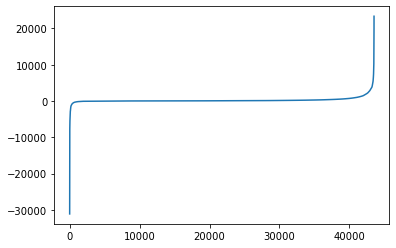

revenue


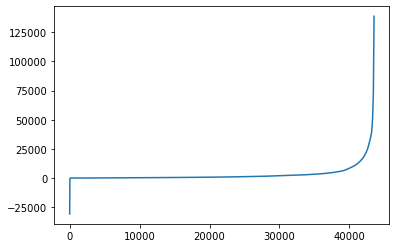

earnings2price


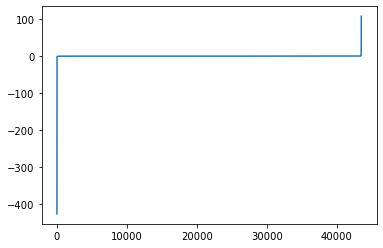

book2price


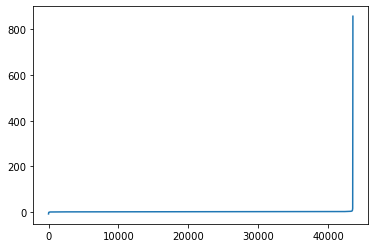

current_ratio


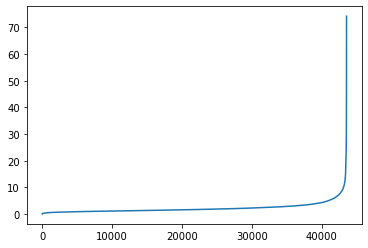

long_term_debt_2_capital


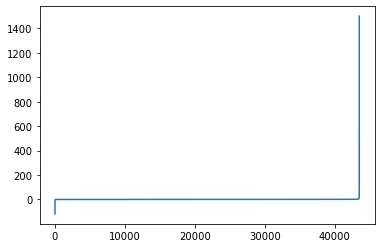

debt2equity_ratio


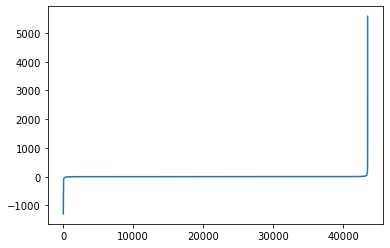

total_non_operating_income2expense


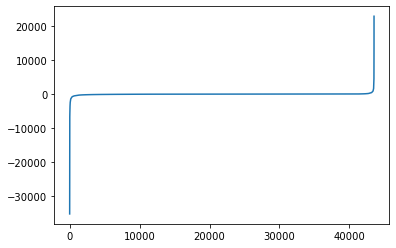

In [12]:
for col in con_cols:
    print(col)
    plt.plot(df[col].sort_values().values)
    plt.show()

# cleanup

before (43524, 12)
after (39551, 12)
before (1177, 13)
after (1041, 13)
net_income


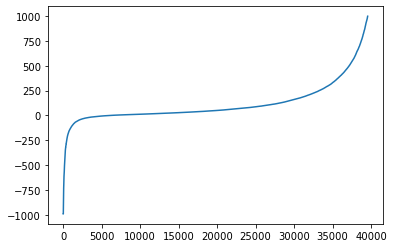

revenue


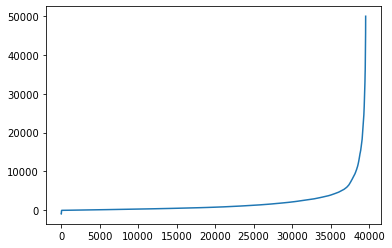

earnings2price


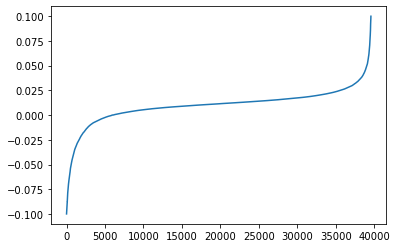

book2price


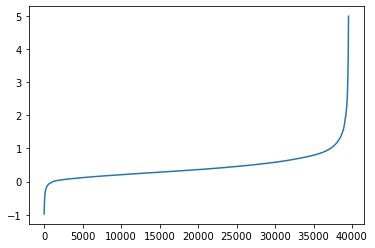

current_ratio


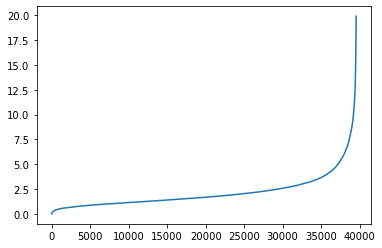

long_term_debt_2_capital


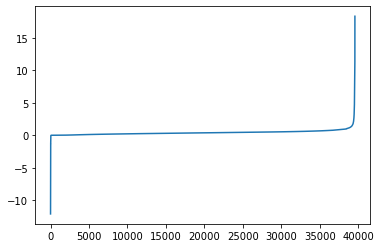

debt2equity_ratio


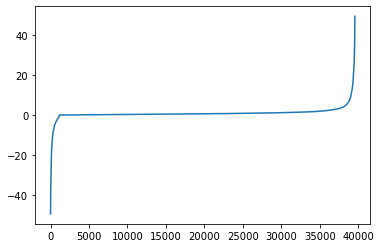

total_non_operating_income2expense


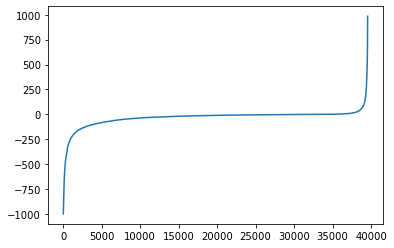

In [13]:
def remove_outliers(df):
    print('before', df.shape)
    df = df.query('-1000 < net_income < 1000')
    df = df.query('-1000 < revenue < 50000')
    df = df.query('-.1 < earnings2price < .1')
    df = df.query('-1 < book2price < 5')
    df = df.query('current_ratio < 20')
    df = df.query('-20 < long_term_debt_2_capital < 20')
    df = df.query('-50 < debt2equity_ratio < 50')
    df = df.query('-1000 < total_non_operating_income2expense < 1000')
    print('after', df.shape)
    return df
    
df     = remove_outliers(df)
latest = remove_outliers(latest)

for col in con_cols:
    print(col)
    plt.plot(df[col].sort_values().values)
    plt.show()

# look for correlations
Strangely there don't seem to be any obvious ones. Even distance vs duration seems mostly random... very surprising...

In [14]:
df[[*lbl_cols, *con_cols]].corr()

,gain_1y,net_income,revenue,earnings2price,book2price,current_ratio,long_term_debt_2_capital,debt2equity_ratio,total_non_operating_income2expense
gain_1y,1.000000,-0.040447,-0.036101,0.018314,0.010488,0.021522,0.008690,-0.005888,0.033647
net_income,-0.040447,1.000000,0.480518,0.430046,-0.026475,-0.154748,-0.016055,-0.010983,-0.073625
revenue,-0.036101,0.480518,1.000000,0.120176,0.073531,-0.183396,0.008069,0.013127,-0.235797
earnings2price,0.018314,0.430046,0.120176,1.000000,0.117504,-0.160386,-0.032052,-0.005896,0.083699
book2price,0.010488,-0.026475,0.073531,0.117504,1.000000,-0.079441,-0.161148,0.005012,-0.095129
current_ratio,0.021522,-0.154748,-0.183396,-0.160386,-0.079441,1.000000,-0.151386,-0.057630,0.171601
long_term_debt_2_capital,0.008690,-0.016055,0.008069,-0.032052,-0.161148,-0.151386,1.000000,0.055675,-0.138856
debt2equity_ratio,-0.005888,-0.010983,0.013127,-0.005896,0.005012,-0.057630,0.055675,1.000000,-0.096026
total_non_operating_income2expense,0.033647,-0.073625,-0.235797,0.083699,-0.095129,0.171601,-0.138856,-0.096026,1.000000


# average value for each category

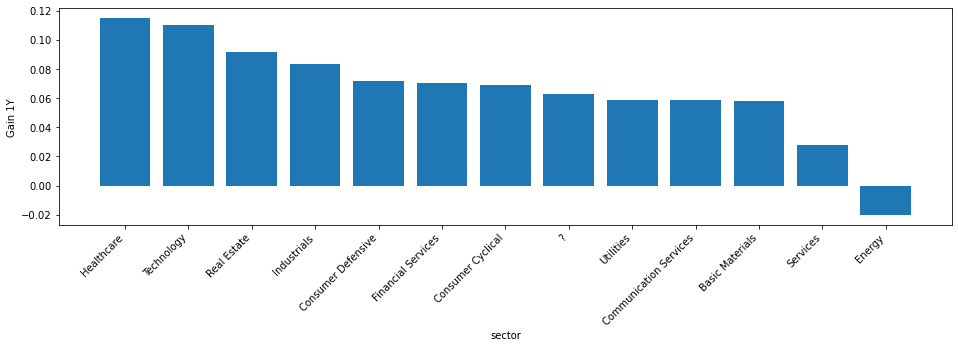

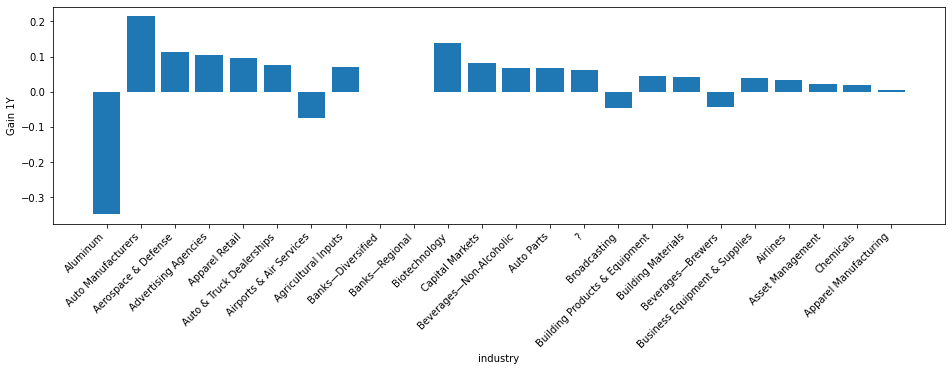

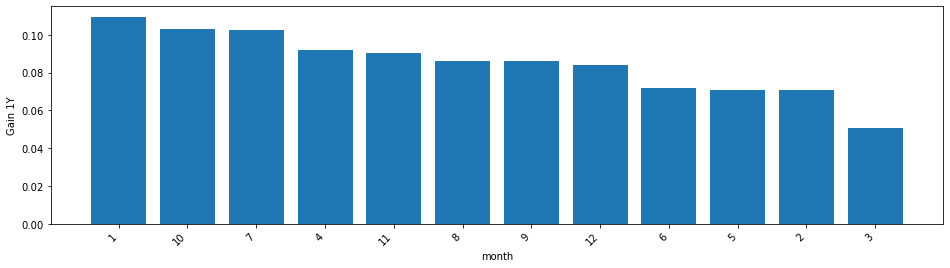

In [15]:
for col in cat_cols:
    means = [(val, df.query(f"`{col}` == {repr(val)}")['gain_1y'].mean()) for val in df[col].cat.categories[:24]]
    top_movers = sorted(means, key=lambda x: abs(x[1]), reverse=True)[:24]
    x, y = zip(*top_movers)
    plt.figure(figsize=(16,4))
    plt.bar(range(len(x)), y)
    plt.xticks(range(len(x)), x, rotation=45, ha='right')
    plt.xlabel(col)
    plt.ylabel('Gain 1Y')
    plt.show()
    

# save category 🠊 embed index mapping
To be used when using model (after training)

In [16]:
cat_to_code = {col: {code: i for i, code in enumerate(df[col].cat.categories)} for col in cat_cols}
cat_to_code['industry']

{'?': 0,
 'Advertising Agencies': 1,
 'Aerospace & Defense': 2,
 'Agricultural Inputs': 3,
 'Airlines': 4,
 'Airports & Air Services': 5,
 'Aluminum': 6,
 'Apparel Manufacturing': 7,
 'Apparel Retail': 8,
 'Asset Management': 9,
 'Auto & Truck Dealerships': 10,
 'Auto Manufacturers': 11,
 'Auto Parts': 12,
 'Banks—Diversified': 13,
 'Banks—Regional': 14,
 'Beverages—Brewers': 15,
 'Beverages—Non-Alcoholic': 16,
 'Biotechnology': 17,
 'Broadcasting': 18,
 'Building Materials': 19,
 'Building Products & Equipment': 20,
 'Business Equipment & Supplies': 21,
 'Capital Markets': 22,
 'Chemicals': 23,
 'Communication Equipment': 24,
 'Computer Hardware': 25,
 'Confectioners': 26,
 'Conglomerates': 27,
 'Consulting Services': 28,
 'Consumer Electronics': 29,
 'Copper': 30,
 'Credit Services': 31,
 'Department Stores': 32,
 'Diagnostics & Research': 33,
 'Discount Stores': 34,
 'Drug Manufacturers—General': 35,
 'Drug Manufacturers—Specialty & Generic': 36,
 'Education & Training Services': 37

# normalize

In [17]:
# Nothing to do... first batchnorm layer takes care of this

# randomize data

In [45]:
df = df.sample(frac=1)

# convert to tensors

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [20]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cats = torch.tensor(cats, dtype=torch.int64).to(device)
cats.shape

torch.Size([39551, 3])

In [21]:
cons = np.stack([df[col].values for col in con_cols], 1)
cons = torch.tensor(cons, dtype=torch.float).to(device)
cons.shape

torch.Size([39551, 8])

In [22]:
lbls = torch.tensor(df[lbl_cols].values, dtype=torch.float).to(device)
lbls.shape

torch.Size([39551, 1])

# set embedding sizes

In [23]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, int(np.log2(size+1))) for size in cat_szs]
emb_szs

[(13, 3), (137, 7), (12, 3)]

# define TabularModel

In [24]:
class TabularModel(nn.Module):

    def __init__(self, cat_to_code, emb_szs, n_cont, out_sz, layers, p=0.25):
        super().__init__()
        self.cat_to_code = cat_to_code
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.LeakyReLU())
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [25]:
model = TabularModel(cat_to_code, emb_szs, cons.shape[1], len(lbl_cols), [64,64,64]).to(device)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(13, 3)
    (1): Embedding(137, 7)
    (2): Embedding(12, 3)
  )
  (emb_drop): Dropout(p=0.25, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=21, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=

# define loss and optimizer

In [26]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6) # 18%
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train / valid / test splits

In [27]:
a = int(cats.shape[0] * .7)
b = int(cats.shape[0] * .85)

cat_train = cats[:a]
con_train = cons[:a]
lbl_train = lbls[:a]

cat_valid = cats[a:b]
con_valid = cons[a:b]
lbl_valid = lbls[a:b]

cat_test = cats[b:]
con_test = cons[b:]
lbl_test = lbls[b:]

In [28]:
len(cat_train)

27685

In [29]:
len(cat_valid)

5933

In [30]:
len(cat_test)

5933

# batch training data so we can randomize samples

In [31]:
# MICAH not sure if batching and randomizing makes any difference...
# TODO GPU usage is at about 0, how can I utilize more gpu?
batch_size = 1024
batch = lambda data: [data[i:i+batch_size] for i in range(0, len(cat_train), batch_size)]
train = [*zip(batch(cat_train), batch(con_train), batch(lbl_train))]
f"{len(train)} batches"

'28 batches'

# train model

In [32]:
import time, random

start_time = time.time()

epochs = 1000

train_losses = []
valid_losses = []

for i in range(epochs):
    model.train()
    train_loss = 0
    random.shuffle(train)
    for cat, con, lbl in train:
        y = model(cat, con)
        loss = torch.sqrt(criterion(y, lbl)) # RMSE
        train_loss += loss.item() * len(cat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(cat_train)
        
    if i and i%5 == 0:
        model.eval()
        with torch.no_grad():
            y = model(cat_valid, con_valid)
            loss = torch.sqrt(criterion(y, lbl_valid)) # RMSE
            valid_loss = loss.item()
            
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
            
        print(f'epoch: {i:3}  train loss: {train_loss:6.3f} valid loss: {valid_loss:6.3f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   5  train loss:  0.362 valid loss:  0.360
epoch:  10  train loss:  0.356 valid loss:  0.359
epoch:  15  train loss:  0.356 valid loss:  0.359
epoch:  20  train loss:  0.355 valid loss:  0.358
epoch:  25  train loss:  0.355 valid loss:  0.358
epoch:  30  train loss:  0.355 valid loss:  0.358
epoch:  35  train loss:  0.354 valid loss:  0.358
epoch:  40  train loss:  0.354 valid loss:  0.358
epoch:  45  train loss:  0.354 valid loss:  0.358
epoch:  50  train loss:  0.354 valid loss:  0.357
epoch:  55  train loss:  0.354 valid loss:  0.357
epoch:  60  train loss:  0.354 valid loss:  0.357
epoch:  65  train loss:  0.353 valid loss:  0.356
epoch:  70  train loss:  0.354 valid loss:  0.356
epoch:  75  train loss:  0.353 valid loss:  0.356
epoch:  80  train loss:  0.353 valid loss:  0.355
epoch:  85  train loss:  0.352 valid loss:  0.355
epoch:  90  train loss:  0.352 valid loss:  0.355
epoch:  95  train loss:  0.352 valid loss:  0.355
epoch: 100  train loss:  0.351 valid loss:  0.354


epoch: 825  train loss:  0.336 valid loss:  0.349
epoch: 830  train loss:  0.335 valid loss:  0.349
epoch: 835  train loss:  0.337 valid loss:  0.349
epoch: 840  train loss:  0.336 valid loss:  0.349
epoch: 845  train loss:  0.337 valid loss:  0.349
epoch: 850  train loss:  0.336 valid loss:  0.349
epoch: 855  train loss:  0.334 valid loss:  0.348
epoch: 860  train loss:  0.335 valid loss:  0.348
epoch: 865  train loss:  0.335 valid loss:  0.348
epoch: 870  train loss:  0.337 valid loss:  0.349
epoch: 875  train loss:  0.335 valid loss:  0.348
epoch: 880  train loss:  0.337 valid loss:  0.349
epoch: 885  train loss:  0.337 valid loss:  0.349
epoch: 890  train loss:  0.334 valid loss:  0.349
epoch: 895  train loss:  0.337 valid loss:  0.349
epoch: 900  train loss:  0.336 valid loss:  0.348
epoch: 905  train loss:  0.335 valid loss:  0.349
epoch: 910  train loss:  0.336 valid loss:  0.349
epoch: 915  train loss:  0.336 valid loss:  0.349
epoch: 920  train loss:  0.337 valid loss:  0.350


# plot the loss function

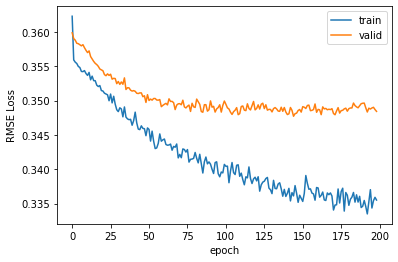

In [33]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

# test loss

In [34]:
model.eval()
with torch.no_grad():
    y = model(cat_test, con_test)

test_loss = torch.sqrt(criterion(y, lbl_test))
f"test loss: {test_loss:5.3f}"

'test loss: 0.337'

# predictions

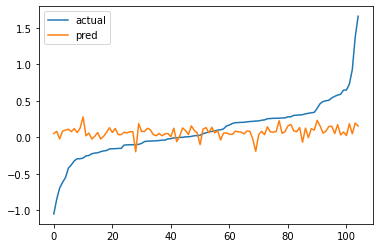

In [43]:
actual = lbl_test.view(-1).cpu()
pred = y.view(-1).cpu()

actual_, pred_ = zip(*sorted(zip(actual[::10].tolist(), pred[::10].tolist()), key=lambda x: x[0]))
plt.plot(actual_, label='actual')
plt.plot(pred_, label='pred')
plt.legend()

# errors

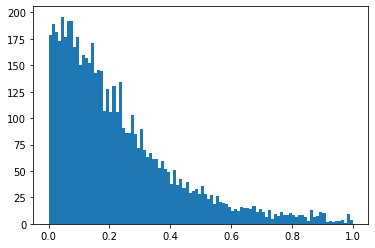

In [36]:
error = abs(pred - actual)
plt.hist(error, 100, range=(0, 1))
plt.show()

# plot gradients

In [37]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.2, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.2, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

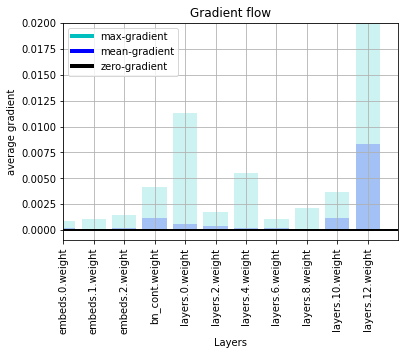

In [38]:
model.train()
y = model(cat_test, con_test)
loss = torch.sqrt(criterion(y, lbl_test))
optimizer.zero_grad()
loss.backward()
plot_grad_flow(model.named_parameters())

# find best ticker now!

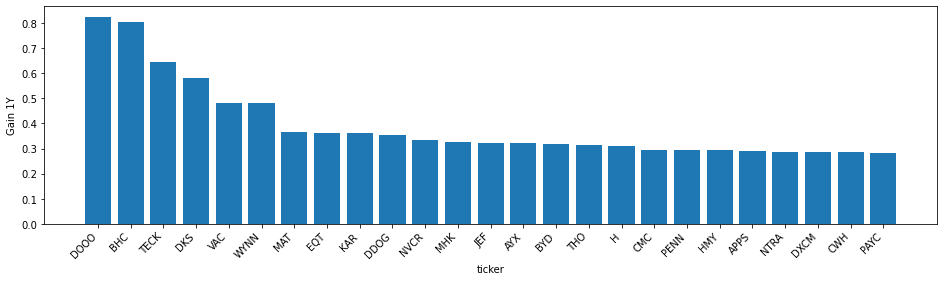

In [39]:
cats = np.stack([latest[col].cat.codes.values for col in cat_cols], 1)
cats = torch.tensor(cats, dtype=torch.int64).to(device)

cons = np.stack([latest[col].values for col in con_cols], 1)
cons = torch.tensor(cons, dtype=torch.float).to(device)

model.eval()
with torch.no_grad():
    y = model(cats, cons)
    
predict = [x for x in zip(latest['ticker'], y.view(-1).tolist())]
best = sorted(predict, key=lambda x:x[1], reverse=True)[:25]
tickers, gains = zip(*best)
gains = np.exp(gains)-1

n = range(len(tickers))
plt.figure(figsize=(16,4))
plt.bar(n, gains)
plt.xticks(n, tickers, rotation=45, ha='right')
plt.xlabel('ticker')
plt.ylabel('Gain 1Y')
plt.show()

In [40]:
pd.concat([latest.query(f"ticker == '{ticker}'") for ticker in tickers])

,ticker,sector,industry,month,net_income,revenue,earnings2price,book2price,current_ratio,long_term_debt_2_capital,debt2equity_ratio,total_non_operating_income2expense,date
0,DOOO,Consumer Cyclical,Recreational Vehicles,4,-164.3246,894.1876,-0.060067,-0.211649,0.9209,1.6908,-3.3770,-77.9451,2020-04-30
0,BHC,Healthcare,Drug Manufacturers—Specialty & Generic,6,-326.0000,1664.0000,-0.051083,0.085414,1.1187,0.9781,44.6117,-410.0000,2020-06-30
0,TECK,Basic Materials,Other Industrial Metals & Mining,3,-232.6584,1772.5290,-0.059944,4.374429,1.3507,0.1881,0.2481,-504.0932,2020-03-31
0,DKS,Consumer Cyclical,Specialty Retail,4,-143.4220,1333.2280,-0.056066,0.651793,2.0352,0.5222,1.0928,-21.5670,2020-04-30
0,VAC,Consumer Cyclical,Resorts & Casinos,6,-70.0000,480.0000,-0.020966,0.826754,3.6471,0.6267,1.6790,-40.0000,2020-06-30
0,WYNN,Consumer Cyclical,Resorts & Casinos,6,-637.5640,85.6980,-0.081147,0.034551,2.2656,0.9788,47.1543,-130.9150,2020-06-30
0,MAT,Consumer Cyclical,Leisure,6,-109.1720,732.1360,-0.032563,0.026082,1.4665,0.9707,37.7355,-50.1920,2020-06-30
0,EQT,Energy,Oil & Gas E&P,6,-263.0750,527.0740,-0.092046,3.304111,0.9880,0.3279,0.4895,20.8340,2020-06-30
0,KAR,Consumer Cyclical,Specialty Retail,6,-34.4000,419.0000,-0.019081,0.850134,1.6180,0.5864,1.4353,-32.2000,2020-06-30
0,DDOG,Technology,Software—Application,6,0.2840,140.0120,0.000000,0.035831,6.7358,0.4015,0.6869,0.1720,2020-06-30


# save the model

In [41]:
# Interesting: model is loaded in cuda if I don't move to cpu before saving
torch.save(model.cpu(), 'model.pt')

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TabularModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
